In [33]:
from qiskit_machine_learning.datasets import ad_hoc_data

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 

def visualize_counts(probs, num_qubits): 
    # Visualizing the outputs 
    zero_prob = probs.get(0, 0.0)
    top_10 = dict(sorted(probs.items(), key=lambda item: item[1], reverse=True)[:10])
    top_10.update({0: zero_prob})
    by_key = dict(sorted(top_10.items(), key=lambda item: item[0]))
    xvals, yvals = list(zip(*by_key.items()))

    plt.bar(xvals, yvals)
    plt.xticks(rotation=75)
    plt.title("Results of sampling")
    plt.xlabel("Measured bitstring")
    plt.ylabel("Probability")
    plt.show()
    
def get_training_data():
    # Reading the training data
    df = pd.read_csv("dataset_graph7.csv", sep=",", header=None)
    training_data = df.values[:20, :]
    ind = np.argsort(training_data[:, -1])
    X_train = training_data[ind][:, :-1]

    return X_train

## Mapping training dataset to kernel matrix

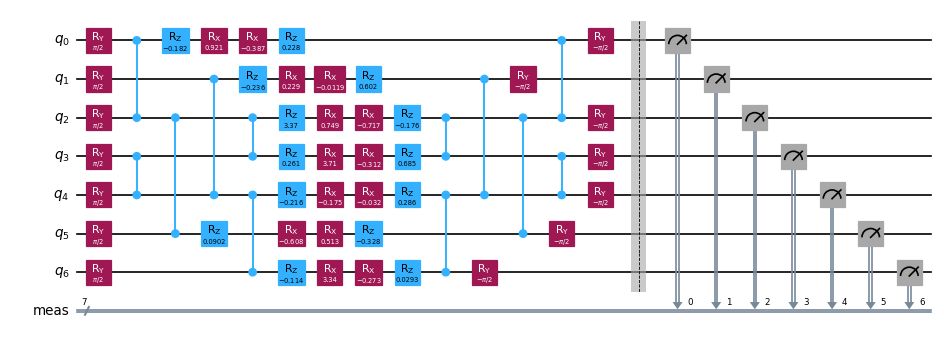

In [35]:
from qiskit.circuit import Parameter, ParameterVector, QuantumCircuit
from qiskit.circuit.library import UnitaryOverlap

# Prepare training dataset
X_train = get_training_data()

num_samples = np.shape(X_train)[0]
kernel_matrix = np.full((num_samples, num_samples), np.nan)

# Feature map to compute overlap
num_features = np.shape(X_train)[1]
num_qubits = int(num_features/2)
entangler_map = [[0,2],[3,4],[2,5],[1,4],[2,3],[4,6]]
fm = QuantumCircuit(num_qubits)
training_param = Parameter("θ")
feature_params = ParameterVector("x", num_qubits*2)
fm.ry(training_param, fm.qubits)

for cz in entangler_map:
    fm.cz(cz[0], cz[1])
for i in range(num_qubits):
    fm.rz(-2 * feature_params[2*i+1], i)
    fm.rx(-2 * feature_params[2*i], i)
    
# Assigning data parameters to first two samples 
x1 = 14
x2 = 19 
unitary1 = fm.assign_parameters(list(X_train[x1]) + [np.pi/2])
unitary2 = fm.assign_parameters(list(X_train[x2]) + [np.pi/2])

# Overlap circuit 
overlap_circ = UnitaryOverlap(unitary1, unitary2)
overlap_circ.measure_all()
overlap_circ.draw('mpl', scale=0.6, style='iqp')

## Optimization for quantum execution

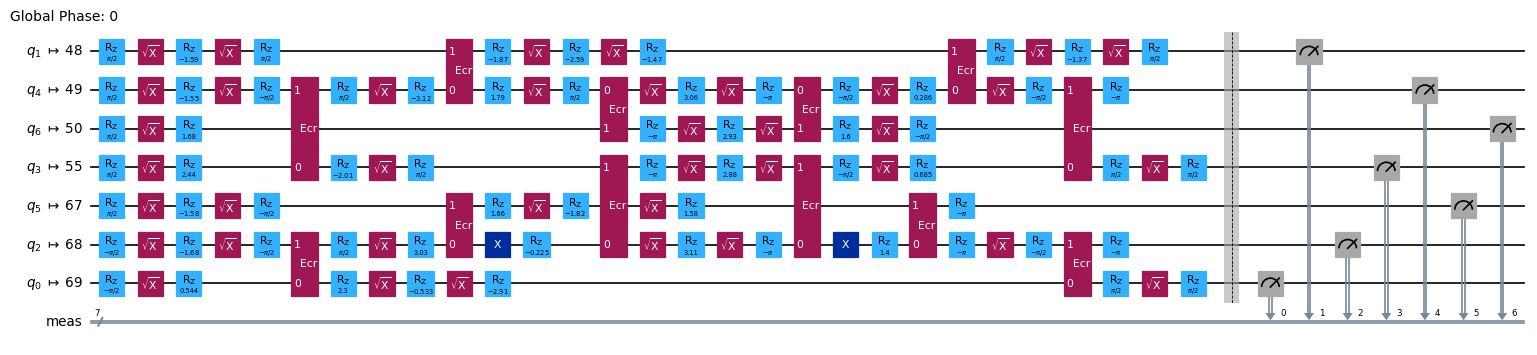

In [36]:
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit_ibm_runtime import QiskitRuntimeService

service = QiskitRuntimeService(channel="ibm_quantum")
backend = service.least_busy(operational=True, simulator=False, min_num_qubits=overlap_circ.num_qubits)

pm = generate_preset_pass_manager(optimization_level=3, backend=backend)
overlap_ibm = pm.run(overlap_circ)
overlap_ibm.draw("mpl", scale=0.6, idle_wires=False, fold=-1, style="iqp")

## Quantum execution

In [54]:
from qiskit.result import QuasiDistribution
from qiskit_ibm_runtime import Options, Session, Sampler


num_shots = 10_000

with Session(service=service, backend=backend) as session:
    sampler = Sampler()
    job = sampler.run([overlap_ibm], shots=num_shots)
    counts_int = job.result()[0].data.meas.get_int_counts()
    counts_bin = job.result()[0].data.meas.get_counts()

/var/folders/yg/gp5xwh8n45zd8mpvl6kvx7yw0000gn/T/ipykernel_8926/2971587013.py:7: DeprecationWarning: The service parameter is deprecated as of qiskit-ibm-runtime 0.26.0 and will be removed no sooner than 3 months after the release date. The service can be extracted from the backend object so it is no longer necessary.
  with Session(service=service, backend=backend) as session:


{0: 0.651, 64: 0.0275, 32: 0.0305, 1: 0.0463, 10: 0.0025, 74: 0.0082, 36: 0.0044, 16: 0.0254, 12: 0.0011, 2: 0.0327, 4: 0.0676, 5: 0.0176, 24: 0.0086, 88: 0.0006, 65: 0.0023, 56: 0.0007, 20: 0.0094, 8: 0.0092, 33: 0.0035, 26: 0.0031, 66: 0.0016, 18: 0.0045, 6: 0.0031, 52: 0.0005, 34: 0.0016, 97: 0.0003, 37: 0.0029, 22: 0.0009, 28: 0.0032, 68: 0.0032, 60: 0.0001, 48: 0.0018, 27: 0.0003, 45: 0.0014, 80: 0.0011, 100: 0.0002, 21: 0.0015, 69: 0.0007, 41: 0.0009, 96: 0.0011, 72: 0.001, 17: 0.0015, 101: 0.0001, 30: 0.0004, 110: 0.0003, 3: 0.0022, 29: 0.0003, 86: 0.0003, 31: 0.0002, 14: 0.0004, 53: 0.0003, 40: 0.0006, 9: 0.0013, 82: 0.0007, 47: 0.0003, 78: 0.0013, 92: 0.0002, 70: 0.0002, 75: 0.0004, 91: 0.0001, 49: 0.0001, 55: 0.0001, 106: 0.0001, 84: 0.0001, 90: 0.0005, 104: 0.0002, 99: 0.0001, 58: 0.0003, 25: 0.0004, 73: 0.0001, 77: 0.0001, 51: 0.0001, 13: 0.0005, 15: 0.0001, 35: 0.0003, 50: 0.0001, 23: 0.0002, 107: 0.0001, 7: 0.0004, 39: 0.0001, 19: 0.0002, 61: 0.0002, 38: 0.0001, 94: 0.000

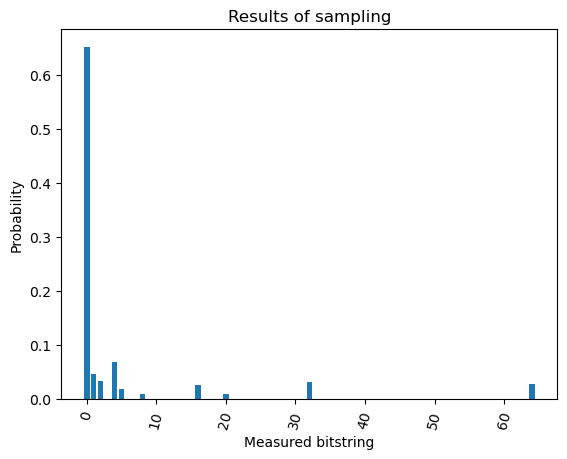

In [57]:
    final_distribution_int = {key: val/num_shots for key, val in counts_int.items()}
    final_distribution_bin = {key: val/num_shots for key, val in counts_bin.items()}
    print(final_distribution_int)

visualize_counts(final_distribution_int, num_qubits)

### Post-processing

In [58]:
# Probability to measure 0
kernel_matrix[x1, x2] = final_distribution_int.get(0, 0.0)
print(f"Fidelity: {kernel_matrix[x1, x2]}")

Fidelity: 0.651
